# Test


In [1]:
import sqlite3 
import os
import re, pandas as pd, numpy as np, time, PyPDF2
import glob

### "Pre processing" the data 


In [2]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\farah\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
df = pd.read_excel('content\ground_truth\data.xlsx')
ground_truth_df = df[['Study_ID', 'Study', 'Allocation', 'Experimenter']]
ground_truth_df

,Study_ID,Study,Allocation,Experimenter
0,1,Chacko et al 2017,Random,Parent
1,1,Chacko et al 2017,Random,Parent
2,2,Coyne et al 2004,Non-random,Teacher
3,2,Coyne et al 2004,Non-random,Teacher
4,3,Purpura et al 2017,Random,Researcher
...,...,...,...,...
311,54,Hassinger-Das (2013),Random,Researcher
312,54,Hassinger-Das (2013),Random,Researcher
313,54,Hassinger-Das (2013),Random,Researcher
314,27,Crandell 2010,Random,Teacher


In [4]:
# extracting data from the csv files in the extracted directory

extracted_dir = 'content/extracted'
extracted_dfs = []

#def extract_data_from_csv(extracted_dir, extracted_dfs):
if os.path.exists(extracted_dir):
    for filename in os.listdir(extracted_dir):
        if filename.endswith('.csv'):
            file_path = os.path.join(extracted_dir, filename)
            try:
                df = pd.read_csv(file_path)
                extracted_dfs.append(df)
                print(f"Loaded {filename}")
            except Exception as e:
                print(f"Failed to load {filename}: {e}")

if extracted_dfs:
    extracted_combined_df = pd.concat(extracted_dfs, ignore_index=True)
    print("Combined DataFrame created.")
else:
    print("No CSV files found in the directory.")

Loaded Aram and Biron - 2004 - Joint storybook reading and joint writing interventions among low SES preschoolers differential con.pdf.csv
Loaded Bianco et al. - 2010 - Early Training in Oral Comprehension and Phonological Skills Results of a Three-Year Longitudinal S.pdf.csv
Loaded Biemiller and Boote - 2006 - An Effective Method for Building Meaning Vocabulary in Primary Grades.pdf.csv
Loaded Blom-Hoffman et al. - 2007 - Instructing Parents to Use Dialogic Reading Strategies with Preschool Children Impact of a Video-Ba.pdf.csv
Loaded Coyne et al. - 2004 - Teaching Vocabulary During Shared Storybook Readings An Examination of Differential Effects.pdf.csv
Loaded Coyne et al. - 2010 - Direct and Extended Vocabulary Instruction in Kindergarten Investigating Transfer Effects.pdf.csv
Loaded Fontes and Cardoso-Martins - 2004 - Efeitos da leitura de histórias no desenvolvimento da linguagem de crianças de nível sócio-econômico.pdf.csv
Loaded Korat and Shamir - 2007 - Electronic books versus 

In [ ]:
def extract_data_from_csv(extracted_dir):
    """
    Loads all CSV files from the given directory into a combined DataFrame.
    Args:
        extracted_dir (str): Path to the directory containing CSV files.
    Returns:
        pd.DataFrame: Combined DataFrame of all loaded CSV files.
    """
    print(f"Extracting data from CSV files in directory: {extracted_dir}")
    if os.path.exists(extracted_dir):
        for filename in os.listdir(extracted_dir):
            if filename.endswith('.csv'):
                file_path = os.path.join(extracted_dir, filename)
                try:
                    df = pd.read_csv(file_path)
                    extracted_dfs.append(df)
                    #print(f"Loaded {filename}")
                except Exception as e:
                    print(f"Failed to load {filename}: {e}")

    if extracted_dfs:
        extracted_combined_df = pd.concat(extracted_dfs, ignore_index=True)
        print("Combined DataFrame created.")
        print(f"Total rows in combined DataFrame: {len(extracted_combined_df)}")
        print("-"* 40)
        return extracted_combined_df
    else:
        print("No CSV files found in the directory.")
        return pd.DataFrame()

In [6]:
extracted_combined_df = extract_data_from_csv(extracted_dir)

Extracting data from CSV files in directory: content/extracted
Combined DataFrame created.
Total rows in combined DataFrame: 38
----------------------------------------


In [7]:
def extract_data_from_csv_in_dir(ext_splitted = [], directory='content/extracted_*'):
    # Get all directory names matching the pattern
    ext_splitted_dir = [d for d in glob.glob(directory) if os.path.isdir(d)]

    for dir in ext_splitted_dir:
        if os.path.exists(dir):
            print(f"Extracted data from {dir}")
            ext_splitted.append({'dir': dir, 'data': extract_data_from_csv(dir)})

#### To group the tables by Study

In [8]:
# directly taken from Anna's code
import re
import unicodedata

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return "".join([c for c in nfkd_form if not unicodedata.combining(c)])

def format_studyName(study_name_string):
    """
    Cuts a string after the last four-digit number, assuming it represents the year.

    Args:
        study_name_string (str): The input string potentially containing a year.

    Returns:
        str: The string cut after the year, or the original string if no year is found.
    """
    # Get rid of all the points, -
    study_name_string = study_name_string.replace('.', '')
    study_name_string = study_name_string.replace(',', '')
    study_name_string = study_name_string.replace(' - ', ' ')
    study_name_string = study_name_string.replace(')', '')
    study_name_string = study_name_string.replace('(', '')
    study_name_string = study_name_string.replace('&', 'and')
    study_name_string = remove_accents(study_name_string)
    # Find all occurrences of four consecutive digits (potential years)
    year_matches = list(re.finditer(r'\b\d{4}\b', study_name_string))

    if year_matches:
        # Get the last match
        last_year_match = year_matches[-1]
        # Get the end index of the last year match
        end_of_year_index = last_year_match.end()
        # Slice the string up to the end of the year
        cut_string = study_name_string[:end_of_year_index]
        return cut_string.strip() # Use strip to remove trailing whitespace
    else:
        # If no four-digit number is found, return the original string
        return study_name_string.strip()

In [9]:
#provided by Anna 
def accuracy_check(col_name, df_extracted, test_table):
  allocation_match = False
  experimenter_match = False

  # Check if both dataframes have the expected columns and rows
  if col_name in df_extracted.columns and \
    not df_extracted.empty and not test_table.empty:

      extracted_allocation = df_extracted[col_name].iloc[0]

      ground_truth_allocation = test_table[col_name].iloc[0]

      # Simple case-insensitive comparison
      if str(extracted_allocation).lower() == str(ground_truth_allocation).lower():
          allocation_match = True
          print(f'{col_name}: Match')
      else:
          print(f"{col_name}: Mismatch (Extracted: '{extracted_allocation}', Ground Truth: '{ground_truth_allocation}')")
  else:
    print("Cannot perform accuracy check: Extracted or ground truth data is missing or malformed.")
  print("--------------------")

In [10]:
accuracy_check('Allocation', extracted_combined_df, ground_truth_df)
accuracy_check('Experimenter', extracted_combined_df, ground_truth_df)

Allocation: Match
--------------------
Experimenter: Mismatch (Extracted: 'Teacher', Ground Truth: 'Parent')
--------------------


In [11]:
ext_splitted = []
extract_data_from_csv_in_dir(ext_splitted, directory='content/extracted_*')

Extracted data from content\extracted_split_1_shuffle_1
Extracting data from CSV files in directory: content\extracted_split_1_shuffle_1
Combined DataFrame created.
Total rows in combined DataFrame: 56
----------------------------------------
Extracted data from content\extracted_split_1_shuffle_2
Extracting data from CSV files in directory: content\extracted_split_1_shuffle_2
Combined DataFrame created.
Total rows in combined DataFrame: 74
----------------------------------------
Extracted data from content\extracted_split_2_shuffle_1
Extracting data from CSV files in directory: content\extracted_split_2_shuffle_1
Combined DataFrame created.
Total rows in combined DataFrame: 91
----------------------------------------
Extracted data from content\extracted_split_2_shuffle_2
Extracting data from CSV files in directory: content\extracted_split_2_shuffle_2
Combined DataFrame created.
Total rows in combined DataFrame: 108
----------------------------------------
Extracted data from content

In [12]:
def format_name_and_accuracy_check(ext_splitted, ground_truth_df):
    for ext in ext_splitted:
        ext['data']['Study'] = ext['data']['Study'].apply(format_studyName)
        print(f"Formatted Study names in {ext['dir']}")
        accuracy_check('Allocation', ext['data'], ground_truth_df)
        accuracy_check('Experimenter', ext['data'], ground_truth_df)

In [13]:
format_name_and_accuracy_check(ext_splitted, ground_truth_df)

Formatted Study names in content\extracted_split_1_shuffle_1
Allocation: Match
--------------------
Experimenter: Mismatch (Extracted: 'Teacher', Ground Truth: 'Parent')
--------------------
Formatted Study names in content\extracted_split_1_shuffle_2
Allocation: Match
--------------------
Experimenter: Mismatch (Extracted: 'Teacher', Ground Truth: 'Parent')
--------------------
Formatted Study names in content\extracted_split_2_shuffle_1
Allocation: Match
--------------------
Experimenter: Mismatch (Extracted: 'Teacher', Ground Truth: 'Parent')
--------------------
Formatted Study names in content\extracted_split_2_shuffle_2
Allocation: Match
--------------------
Experimenter: Mismatch (Extracted: 'Teacher', Ground Truth: 'Parent')
--------------------
Formatted Study names in content\extracted_split_3_shuffle_1
Allocation: Match
--------------------
Experimenter: Mismatch (Extracted: 'Teacher', Ground Truth: 'Parent')
--------------------
Formatted Study names in content\extracted_sp

## Calculating the mesures
Auxilary functions used to calculate the metrics just so it can be easier to read

In [14]:
# Function to calculate various metrics based on true positives, false positives, and false negatives
def calculateAccuracy(TP, FP, FN, TN):
    '''calculates the accuracy of a model based on true positives, true negatives, false positives, and false negatives.'''
    return float(TP + TN / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0)

def calculatePrecision(TP, FP):
    '''calculates the precision of a model based on true positives and false positives.'''
    return float(TP / (TP + FP) if (TP + FP) > 0 else 0)

def calculateRecall(TP, FN):
    '''calculates the recall of a model based on true positives and false negatives.'''
    return float(TP / (TP + FN) if (TP + FN) > 0 else 0)

def calculateF1Score(precision, recall):
    '''calculates the F1 score based on precision and recall.'''
    return float(2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0)

def calculateMetrics(TP, FP, FN, TN):
    '''calculates various metrics based on true positives, false positives, and false negatives.'''
    # --- Metrics ---
    accuracy = calculateAccuracy(TP, FP, FN, TN) 
    recall = calculateRecall(TP, FN)
    precision = calculatePrecision(TP, FP)
    f1 = calculateF1Score(precision, recall)

    return {
        'Accuracy': round(accuracy, 4),
        'Recall': round(recall, 4),
        'Precision': round(precision, 4),
        'F1': round(f1, 4)
    }


In [15]:
# Function to count true positives, false positives, and false negatives
def count_true_positives(gt_df, pred_df, column='Allocation', join_on='Study', positive_value='Random'):
    """
    Counts the number of true positives in the ground truth and predicted dataframes.
    Args:
        gt_df (pd.DataFrame): Ground truth dataframe.
        pred_df (pd.DataFrame): Predicted dataframe.
        column (str): The column name to check for true positives.
        join_on (str): The column name to join the dataframes on.
        positive_value (str): The value considered as a positive case.
    Returns:
        int: The count of true positives.
    """
    merged = gt_df[[join_on, column]].merge(pred_df[[join_on, column]], on=join_on, suffixes=('_gt', '_pred'))
    tp = ((merged[f"{column}_gt"] == positive_value) & (merged[f"{column}_pred"] == positive_value)).sum()
    return tp

def count_false_positives(gt_df, pred_df, column='Allocation', join_on='Study', positive_value='Random'):
    """Counts the number of false positives in the ground truth and predicted dataframes.
    Args:
        gt_df (pd.DataFrame): Ground truth dataframe.
        pred_df (pd.DataFrame): Predicted dataframe.
        column (str): The column name to check for false positives.
        join_on (str): The column name to join the dataframes on.
        positive_value (str): The value considered as a positive case.
    Returns:
        int: The count of false positives.
    """
    merged = gt_df[[join_on, column]].merge(pred_df[[join_on, column]], on=join_on, suffixes=('_gt', '_pred'))
    fp = ((merged[f"{column}_gt"] != positive_value) & (merged[f"{column}_pred"] == positive_value)).sum()
    return fp

def count_false_negatives(gt_df, pred_df, column= 'Allocation', join_on='Study', positive_value='Random'):
    """Counts the number of false negatives in the ground truth and predicted dataframes.
    Args:
        gt_df (pd.DataFrame): Ground truth dataframe.
        pred_df (pd.DataFrame): Predicted dataframe.
        column (str): The column name to check for false negatives.
        join_on (str): The column name to join the dataframes on.
        positive_value (str): The value considered as a positive case.
    Returns:
        int: The count of false negatives."""
    
    merged = gt_df[[join_on, column]].merge(pred_df[[join_on, column]], on=join_on, suffixes=('_gt', '_pred'))
    fn = ((merged[f"{column}_gt"] == positive_value) & (merged[f"{column}_pred"] != positive_value)).sum()
    return fn

def count_true_negatives(gt_df, pred_df, column='Allocation', join_on='Study', positive_value='Random'):
    """Counts the number of true negatives in the ground truth and predicted dataframes.
    Args:
        gt_df (pd.DataFrame): Ground truth dataframe.
        pred_df (pd.DataFrame): Predicted dataframe.
        column (str): The column name to check for true negatives.
        join_on (str): The column name to join the dataframes on.
        positive_value (str): The value considered as a positive case.
    Returns:
        int: The count of true negatives."""
    merged = gt_df[[join_on, column]].merge(pred_df[[join_on, column]], on=join_on, suffixes=('_gt', '_pred'))
    tn = ((merged[f"{column}_gt"] != positive_value) & (merged[f"{column}_pred"] != positive_value)).sum()
    return tn

### Testing the results :
This will probably be deleted or reorgenised to keep the data in a better format for future plots -- Anna did it better so i used her code instead

In [16]:
#Anna's code (cause it's better than mine)

def binary_metrics(ground_truth_df, extracted_df, column='Allocation', join_on='Study', positive_value='Random'):
  tp = count_true_positives(ground_truth_df, extracted_df, column=column, join_on=join_on, positive_value=positive_value)
  fp = count_false_positives(ground_truth_df, extracted_df, column=column, join_on=join_on, positive_value=positive_value)
  fn = count_false_negatives(ground_truth_df, extracted_df, column=column, join_on=join_on, positive_value=positive_value)
  tn = count_true_negatives(ground_truth_df, extracted_df, column=column, join_on=join_on, positive_value=positive_value)

  metrics = calculateMetrics(tp, fp, fn, tn)
  print(f'Here are metrics for {column} column:')
  for name, val in metrics.items():
    print(f"{name:10s}: {float(val):.2f}")
  return metrics

binary_metrics(ground_truth_df, extracted_combined_df, column='Allocation', join_on='Study', positive_value='Random')

Here are metrics for Allocation column:
Accuracy  : 0.00
Recall    : 0.00
Precision : 0.00
F1        : 0.00


{'Accuracy': 0.0, 'Recall': 0.0, 'Precision': 0.0, 'F1': 0.0}

In [17]:
#for ext in ext_splitted:
    #print(f"Mesures for {ext['dir']}:")
    #binary_metrics(ground_truth_df, ext['data'], column='Allocation', join_on='Study', positive_value='Random')

results = []

for ext in ext_splitted:
    metrics = binary_metrics(ground_truth_df, ext['data'], column='Allocation', join_on='Study', positive_value='Random')
    results.append({
        "split": ext['dir'],
        "Accuracy": metrics['Accuracy'],
        "Recall": metrics['Recall'],
        "Precision": metrics['Precision'],
        "F1": metrics['F1']
    })

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

Here are metrics for Allocation column:
Accuracy  : 36.32
Recall    : 1.00
Precision : 0.57
F1        : 0.73
Here are metrics for Allocation column:
Accuracy  : 48.24
Recall    : 1.00
Precision : 0.51
F1        : 0.68
Here are metrics for Allocation column:
Accuracy  : 48.23
Recall    : 0.80
Precision : 0.51
F1        : 0.62
Here are metrics for Allocation column:
Accuracy  : 60.19
Recall    : 0.83
Precision : 0.48
F1        : 0.61
Here are metrics for Allocation column:
Accuracy  : 69.18
Recall    : 0.85
Precision : 0.50
F1        : 0.63
Here are metrics for Allocation column:
Accuracy  : 78.15
Recall    : 0.87
Precision : 0.47
F1        : 0.61
Here are metrics for Allocation column:
Accuracy  : 88.14
Recall    : 0.88
Precision : 0.46
F1        : 0.60
Here are metrics for Allocation column:
Accuracy  : 97.12
Recall    : 0.89
Precision : 0.44
F1        : 0.59
                              split  Accuracy  Recall  Precision     F1
content\extracted_split_1_shuffle_1   36.3226  1.0000   

In [18]:
#Anna's code again (cause i did something really inefficient)

def multiclass_metrics(ground_truth_df,
                       extracted_df,
                       column='Experimenter', join_on='Study',
                       values=['Teacher', 'Parent', 'Researcher', 'Combined - Teacher and Parent']):
  all_metrics = {}
  print(f'Here are average metrics for {column} column:')
  for value in values:
    tp = count_true_positives(ground_truth_df, extracted_df, column=column, join_on=join_on, positive_value=value)
    fp = count_false_positives(ground_truth_df, extracted_df, column=column, join_on=join_on, positive_value=value)
    fn = count_false_negatives(ground_truth_df, extracted_df, column=column, join_on=join_on, positive_value=value)
    tn = count_true_negatives(ground_truth_df, extracted_df, column=column, join_on=join_on, positive_value=value)

    metrics = calculateMetrics(tp, fp, fn, tn)
    print(f'Metrics for {value}:')
    for name, val in metrics.items():
        print(f"{name:10s}: {float(val):.2f}")
    print('--------------------------------------')

    all_metrics[value] = metrics

  # Calculate and print average metrics
  avg_metrics = {
      'Accuracy': np.mean([m['Accuracy'] for m in all_metrics.values()]),
      'Recall': np.mean([m['Recall'] for m in all_metrics.values()]),
      'Precision': np.mean([m['Precision'] for m in all_metrics.values()]),
      'F1': np.mean([m['F1'] for m in all_metrics.values()])
  }
  print(f'Here are average metrics for {column} column:')
  for name, val in avg_metrics.items():
      print(f"{name:10s}: {float(val):.2f}")
  return metrics, avg_metrics

In [19]:
multiclass_metrics(ground_truth_df, extracted_combined_df, column='Experimenter', join_on='Study',
                  values=['Teacher', 'Parent', 'Researcher', 'Combined - Teacher and Parent'])

for ext in ext_splitted:
    multiclass_metrics(ground_truth_df, ext['data'], column='Experimenter', join_on='Study',
                      values=['Teacher', 'Parent', 'Researcher', 'Combined - Teacher and Parent'])

Here are average metrics for Experimenter column:
Metrics for Teacher:
Accuracy  : 0.00
Recall    : 0.00
Precision : 0.00
F1        : 0.00
--------------------------------------
Metrics for Parent:
Accuracy  : 0.00
Recall    : 0.00
Precision : 0.00
F1        : 0.00
--------------------------------------
Metrics for Researcher:
Accuracy  : 0.00
Recall    : 0.00
Precision : 0.00
F1        : 0.00
--------------------------------------
Metrics for Combined - Teacher and Parent:
Accuracy  : 0.00
Recall    : 0.00
Precision : 0.00
F1        : 0.00
--------------------------------------
Here are average metrics for Experimenter column:
Accuracy  : 0.00
Recall    : 0.00
Precision : 0.00
F1        : 0.00
Here are average metrics for Experimenter column:
Metrics for Teacher:
Accuracy  : 30.27
Recall    : 0.47
Precision : 0.88
F1        : 0.61
--------------------------------------
Metrics for Parent:
Accuracy  : 0.94
Recall    : 0.00
Precision : 0.00
F1        : 0.00
-----------------------------

# Plots 
plotting the outputted numbers uwu

In [20]:
%pip install matplotlib
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\farah\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [21]:
def bar_plot_allocation_metrics(metrics_dicts, model_names):
    """
    Plots allocation metrics (Accuracy, Recall, Precision, F1) for different LLMs.

    Args:
        metrics_dicts (list of dict): List of metrics dictionaries, one per model.
        model_names (list of str): List of model names corresponding to metrics_dicts.
    """
    import matplotlib.pyplot as plt

    labels = ['Accuracy', 'Recall', 'Precision', 'F1']
    x = range(len(labels))
    colors = ['hotpink', '#88c999', 'purple', "#92e6df",'#e15759', '#edc949', ]

    plt.figure(figsize=(10, 6))
    width = 0.8 / len(metrics_dicts)  # Adjust bar width based on number of models

    for i, (metrics, name) in enumerate(zip(metrics_dicts, model_names)):
        values = [metrics[label] for label in labels]
        plt.bar([xi + i * width for xi in x], values, width=width, label=name, color=colors[i % len(colors)])

    plt.ylabel('Score')
    plt.title('Allocation and Experimenter metrics (ChatGPT output)')
    plt.xticks([xi + width * (len(metrics_dicts) - 1) / 2 for xi in x], labels)
    plt.ylim(0, 1)
    plt.legend()
    #plt.tight_layout()
    plt.show()

In [ ]:
#bar_plot_allocation_metrics([allocation_metrics, metrics_Experimenter], ['Allocation', 'Experimenter'])

In [ ]:
# Test plot_allocation_metrics with a single model
#bar_plot_allocation_metrics([ metrics_parent, metrics_researcher, metrics_teacher, metrics_Combined], ['Parent', 'Researcher', 'Teacher', 'Combined'])

In [ ]:
def scatter_plot_accuracy_vs_time(accuracies, computing_times, model_names):
    """
    Plots a scatter plot of accuracy vs computing time for each LLM.

    Args:
        accuracies (list): List of accuracy values for each model.
        computing_times (list): List of computing times for each model.
        model_names (list): List of model names (e.g., ['chatgpt', 'llama', 't5']).
    """

    default_colors = ['hotpink', '#88c999', 'purple', 'blue', "#92e6df", '#e15759', '#edc949']
    colors = default_colors * ((len(accuracies) // len(default_colors)) + 1)
    colors = colors[:len(accuracies)]

    plt.figure(figsize=(8, 6))
    plt.scatter(computing_times, accuracies, color= colors, s=100)

    for i, name in enumerate(model_names):
        plt.annotate(name, (computing_times[i], accuracies[i]), textcoords="offset points", xytext=(5,5), ha='left')

    plt.xlabel('Computing Time (s)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Computing Time for LLMs')
    plt.grid(True)
    plt.show()

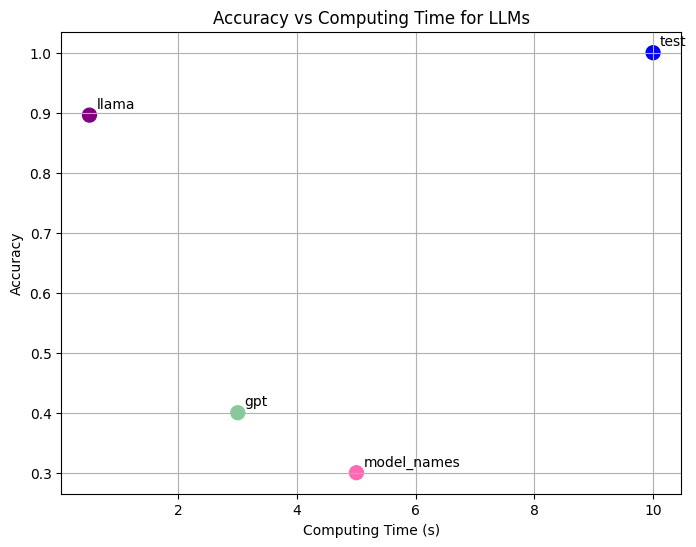

In [ ]:
# Test the scatter_plot_accuracy_vs_time function with available data
scatter_plot_accuracy_vs_time([0.3, 0.4, 0.896, 1], [5, 3, 0.5, 10], ['model_names', 'gpt', 'llama', 'test'])

# To do :
- multiple subplots on a single page side by side